In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# themes and appearance
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_colwidth', 400)

In [2]:
# import data

# training data
df_train = pd.read_pickle('data/df_clean.pickle')[['song', 'artist', 'chord_progression_C']].rename({'chord_progression_C': 'chord_progression'}, axis=1)

# data predicted from transformer models
df_m1k = pd.read_pickle('data/df_m1k.pickle').reset_index(drop=True)
df_m10k = pd.read_pickle('data/df_m10k.pickle').reset_index(drop=True)
df_m4 = pd.read_pickle('data/df_m4.pickle').reset_index(drop=True)
df_m4u = pd.read_pickle('data/df_m4u.pickle').reset_index(drop=True)

In [3]:
def how_big():
    # this is slow, but doesn't break everything by converting datatypes in place (.astype('str') bug in pandas)
    print(
        df_train.chord_progression.sort_values().value_counts().shape[0],
        df_m1k.chord_progression.sort_values().value_counts().shape[0],
        df_m10k.chord_progression.sort_values().value_counts().shape[0],
        df_m4.chord_progression.sort_values().value_counts().shape[0],
        df_m4u.chord_progression.sort_values().value_counts().shape[0]
    )

how_big()

4713 4669 3548 4324 6507


In [4]:
def clean_chord_progressions(df):
    # loop through and replace duplicated progressions with half until no duplicates are left
    for _ in range(100):
        counter = 0
        for i, row in df.iterrows():
            chords = row['chord_progression']
            if len(chords) == 1:
                continue
            if chords[:len(chords)//2] == chords[len(chords)//2:]:
                df.at[i, 'chord_progression'] = chords[:len(chords)//2]
                counter += 1
            if chords[:len(chords)//3] == chords[len(chords)//3:2*len(chords)//3] == chords[2*len(chords)//3:]:
                df.at[i, 'chord_progression'] = chords[:len(chords)//3]
                counter += 1
        if counter == 0:
            break
    
    # update progressions to remove repeated chords
    for i, row in df.iterrows():
        progression = row['chord_progression']
        clean_progression = [progression[0]]
        for chord in progression[1:]:
            if chord != clean_progression[-1]:
                clean_progression.append(chord)
        df.at[i, 'chord_progression'] = clean_progression 
    
    return df


In [5]:
# before checks
display(df_m10k.iloc[[11815, 10887, 13887]])
display(df_m10k.iloc[[14400, 2533, 3370, 12478]])

,chord_progression
11815,"[Am, Am]"
10887,"[Am, Am, Am]"
13887,"[Am, Am, C, G]"


,chord_progression
14400,"[Dm, Am, Dm, Am, Dm, Am]"
2533,"[Dm, Am, Dm, Am, Dm, Am]"
3370,"[Dm, Am, Dm, Am, Dm, Am]"
12478,"[Dm, Am, Dm, Am, Dm, Am]"


In [6]:
%%time

df_train = clean_chord_progressions(df_train)
df_m1k = clean_chord_progressions(df_m1k)
df_m10k = clean_chord_progressions(df_m10k)
df_m4 = clean_chord_progressions(df_m4)
df_m4u = clean_chord_progressions(df_m4u)

how_big()

4405 4348 3303 4020 6268
Wall time: 18.3 s


In [7]:
# after checks
display(df_m10k.iloc[[11815, 10887, 13887]])
display(df_m10k.iloc[[14400, 2533, 3370, 12478]])

,chord_progression
11815,[Am]
10887,[Am]
13887,"[Am, C, G]"


,chord_progression
14400,"[Dm, Am]"
2533,"[Dm, Am]"
3370,"[Dm, Am]"
12478,"[Dm, Am]"


In [8]:
# now drop all 1 chord rows (or > 8 chord rows)
df_train = df_train[(df_train.chord_progression.apply(len) > 1) & (df_train.chord_progression.apply(len) < 9)].reset_index(drop=True)
len_dataset = df_train.shape[0]

df_m1k = df_m1k[df_m1k.chord_progression.str.len()>1].reset_index(drop=True).iloc[0:len_dataset]
df_m10k = df_m10k[df_m10k.chord_progression.str.len()>1].reset_index(drop=True).iloc[0:len_dataset]
df_m4 = df_m4[df_m4.chord_progression.str.len()>1].reset_index(drop=True).iloc[0:len_dataset]
df_m4u = df_m4u[df_m4u.chord_progression.str.len()>1].reset_index(drop=True).iloc[0:len_dataset]

# check sizes
df_train.shape[0], df_m1k.shape[0], df_m10k.shape[0], df_m4.shape[0], df_m4u.shape[0]

(16706, 16706, 16706, 16706, 16706)

## Most Popular Chord Progressions

In [9]:
def top_progressions(dataframe, name='', n=99999):
    df = pd.DataFrame(dataframe.chord_progression.astype('str').value_counts().head(n)).reset_index()
    df['chord_progression'] = df['chord_progression'].replace("['\[\],]", '', regex=True)
    return df.rename({'count': f'{name}'}, axis=1)


In [10]:
def combine_counts():
    df = top_progressions(df_train, 'train_counts')
    
    df1 = top_progressions(df_m1k, 'm1k_counts')
    df2 = top_progressions(df_m10k, 'm10k_counts')
    df3 = top_progressions(df_m4, 'm4_counts')
    df4 = top_progressions(df_m4u, 'm4u_counts')
    
    for d in [df1, df2, df3, df4]:
        df = pd.merge(df, d, on='chord_progression', how='outer')
    
    numeric_columns = [x for x in df.columns if x != 'chord_progression']
    df[numeric_columns] = df[numeric_columns].astype('Int64')
    df['total_counts'] = df[numeric_columns].sum(axis=1)
    
    return df.sort_values('total_counts', ascending=False).reset_index(drop=True)


In [11]:
# top chord progressions by method
progression_counts = combine_counts().drop('total_counts', axis=1).fillna(0)

display(progression_counts.head())
display(progression_counts.tail())

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
0,C G Am F,427,595,620,427,255
1,Am F C G,438,425,446,509,226
2,F C G,338,365,226,335,419
3,C F,279,292,356,290,217
4,F C G Am,245,251,272,272,141


,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
13853,Dm F C Dm F Am,0,0,1,0,0
13854,C G C Am Dm G C,0,0,1,0,0
13855,C Gsus4 Dm,0,0,1,0,0
13856,F G C F C F C,0,0,1,0,0
13857,Am G C G F Am,0,0,0,0,1


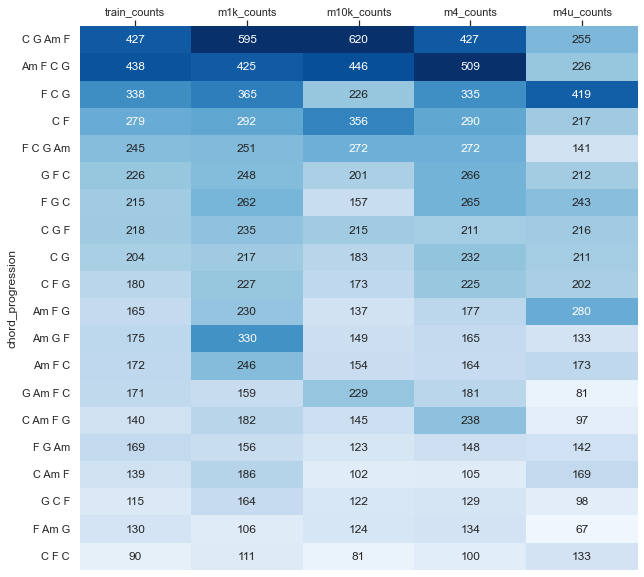

In [12]:
# plot as a heatmap

# how many chord progressions to plot
top_n = 20

plt.figure(figsize=(10, top_n//2))
fig = sns.heatmap(
    progression_counts.head(top_n).set_index('chord_progression').astype(float), 
    cmap='Blues', 
    annot=True, 
    fmt='g', 
    cbar=False, 
    vmin=50, 
    vmax=500
)
fig.xaxis.tick_top()
plt.show()

## Chord Progressions Not In Training Set

In [13]:
# mostly dominated by the underfit model (is it more "creative"?)
unique = progression_counts[progression_counts.train_counts==0]
unique.head(20)

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
177,G C,0,9,1,2,50
254,F C,0,17,1,2,17
286,G C G,0,4,0,1,29
323,G Am,0,2,0,0,27
336,G C Am,0,0,1,1,26
403,F C Am,0,0,0,0,23
412,G C Am F G,0,2,0,4,16
448,G C G Am,0,0,0,1,19
458,Am7 F G,0,4,0,0,15
460,Dm G C G,0,2,0,1,16


In [14]:
# what about the top 10 from the underfit model
unique.sort_values('m4u_counts', ascending=False).head(10)

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
177,G C,0,9,1,2,50
286,G C G,0,4,0,1,29
323,G Am,0,2,0,0,27
336,G C Am,0,0,1,1,26
403,F C Am,0,0,0,0,23
448,G C G Am,0,0,0,1,19
254,F C,0,17,1,2,17
524,G C Em,0,1,0,0,16
460,Dm G C G,0,2,0,1,16
412,G C Am F G,0,2,0,4,16


In [15]:
# let's check the overfit model (it predicts common pop progressions more often, is it more "cheesy"?)
unique.sort_values('m10k_counts', ascending=False).head(10)

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
1476,Dm C Dm C Dm,0,1,4,0,0
2008,Em Am Dm G C,0,0,4,0,0
1313,Am Dm G C F,0,2,4,0,0
978,Am G Am G F,0,4,3,0,1
2752,C G Am G F G F G,0,0,3,0,0
2737,G F C Am G F,0,0,3,0,0
2730,C Fadd9 C Fadd9 Dm Fadd9,0,0,3,0,0
2729,Dm C Dm C Dm C Dm,0,0,3,0,0
2728,C G C G F C G F,0,0,3,0,0
2727,F G F G C G Am G,0,0,3,0,0
